
# Mean variance optimization

**This is an advanced notebook which requires prior knowledge on optimization and linear algebra**

The [CVXOPT ](https://cvxopt.org) library can solve convex optimization problems. In Modelflow this is harnesses to solve **mean variance** problems as they frequently arise in finance.  

This notebook first takes the reader through how a mean variance problem can be restated as a quadratic problem, which is a standard problem for CVXOPT. It covers a little more general mean variance problem which also a stylized bank balance sheet optimization problem.  

**The notebook is fairly advanced and requires some previous knowledge.** 

A small currency mix optimization model with 3 currencies is used to illustrate the optimization. 

Notice also that the rows in this example has nothing to do with time, but indicates the risk level. This does not matter, as no lags or leads are involved. 

Enjoy 

In [ ]:
#This is code to manage dependencies if the notebook is executed in the google colab cloud service
if 'google.colab' in str(get_ipython()):
  import os
  os.system('apt -qqq install graphviz')
  os.system('pip -qqq install ModelFlowIb ipysheet  --no-dependencies ')
  incolab = True  
else:
  incolab = False 

In [1]:

import matplotlib.pyplot as plt
import pandas as pd 

# Modules from Modelflow
from modelclass import model 

#Optional functionalities 
model.widescreen();
model.scroll_off();

## Mean variance problem

A mean variance problem for allocating positions to banks. 
let: 

$$
\begin{array}{ll}
\mathbf x & \mbox{Position in each asset(+)/liability(-) type}\\
\Sigma & \mbox{Covariance matrix} \\
\mathbf r & \mbox{Return vector}\\
\lambda & \mbox{Risk aversion}\\
\mathbf{riskweights}&\text{Vector of risk weights, liabilities has riskweight = 0}\\
Capital&\text{Max of sum of risk weighted assets}\\
\mathbf{lcrweights}&\text{Vector of LCR weights, liabilities has lcrweight = 0}\\
LCR&\text{Min of sum of lcr weighted assets}\\
\mathbf{leverageweight}&\text{Vector of leverage weights, liabilities has leverageweight = 0}\\
Equity&\text{Max sum of leverage weighted positions}\\
Budget&\text{initial sum of the positions, as no new money is injected the sum has to be maintained }\\
\mbox{Risk} & \mathbf x^T  \Sigma \mathbf x\\
\mbox{Return} & \mathbf r^T \mathbf x\\
\end{array}
$$

The optimization problem can be stated as: 


$$
\begin{array}{lll}
\mbox{minimize:}  & \lambda \mathbf x^T \Sigma \mathbf x - (1-\lambda) \mathbf r^T \mathbf x & \mbox{If }\lambda \mbox{ = 1 minimize risk, if } \lambda\mbox{ = 0 maximize return }\\
\mbox{subject to:} & \mathbf x \succeq \mathbf{x^{min}} &\mbox{Each position greater or equal a minimum}\\ 
                   & \mathbf x \preceq \mathbf{x^{max}} &\mbox{Each position less or equal a maximum}\\ 
                   & \mathbf{riskweights}^T\mathbf x \leq Capital &\mbox{Risk weighted assets less than or equal to capital}\\ 
                   & \mathbf{lcrweights}^T\mathbf x \geq LCR &\mbox{lcr weighted assets greater than or equal to LCR target}\\ 
                   & \mathbf{leverageweight}^T\mathbf x \leq equity &\mbox{leverage weighted assets less than or equal to equity}\\ 
                   & \mathbf 1^T\mathbf x = Budget & \mbox{Sum of positions = E, we are not getting more money}
\end{array}
$$


## Quadratic program

The general quadratic optimization problem is usually formulated in this way: 

$$
\begin{array}{lr}
\mbox{minimize:}   &\frac{1}{2} x^TPx + q^T x \\
\mbox{subject to:} & G x \preceq h \\
                  & Ax = b
\end{array}
$$

P,q,G,h,A,b are the parameters quadratic program algorithms usually have as inputs. 
This also goes for the **cvxopt** package which is used in this example. 

## Translation from Mean Variance to quadratic program
To solve the Mean variance problem the problem has to be translated to the standard quadratic programming formulation. This can be done according to this recipe: 

$$
\begin{array}{ll}
P & = 2\times (1-\lambda)\times  \Sigma \\
q & = -\lambda\times r \\ 
G &= \begin{bmatrix} -x^{min} \\ 
\phantom{-}x^{max} \\ 
 Capital \\ 
 -LCR\\ 
 \end{bmatrix}\\
A &= \mathbf 1^T \\
b &= Budget\\
\end{array}
$$

So in a example with 3 positions $ G \times x \preceq h  $ can be constructed this way:  


$$
\begin{array}{llll}
 \begin{bmatrix} 
		-1 & \phantom{-}0 & \phantom{-}0 \\
		\phantom{-}0 & -1 & \phantom{-}0 \\
		\phantom{-}0 & \phantom{-}0 & -1 \\
		\phantom{-}1 & \phantom{-}0 & \phantom{-}0 \\
		\phantom{-}0 & \phantom{-}1 & \phantom{-}0 \\
		\phantom{-}0 & \phantom{-}0 & \phantom{-}1 \\
   		\text{Risk weight}_{position_1} & \text{Risk weight}_{position_2} & \text{Risk weight}_{position_3} \\
   		\text{-LCR weight}_{position_1} & \text{-LCR weight}_{position_2} & \text{-LCR weight}_{position_3} \\
   		\text{Leverage weight}_{position_1} & \text{Leverage weight}_{position_2} & \text{Leverage weight}_{position_3} \\
\end{bmatrix} \times  \begin{bmatrix} 
		x_1 \\
		x_2  \\
		x_3 \\
\end{bmatrix} \preceq \begin{bmatrix} 
		-x_1^{min} \\
		-x_2^{min} \\
		-x_3^{min} \\
		\phantom{-}x_1^{max} \\
		\phantom{-}x_2^{max} \\
		\phantom{-}x_3^{max} \\
        Capital  \\
        -LCR \\
        Equity \\
\end{bmatrix}
\end{array}
$$



## Grouping af variables 
If we want to group position so that positions have are proportional, it can be done by adding rows to A and b
if $position_{1}$ should be equal to $position_2$ 

\begin{gather*}
A = \begin{bmatrix} 
		1 & \phantom{-}1 & 1 \\
		1 & -1 & 0 \\
		\end{bmatrix} \\        
         b = \begin{bmatrix} 
		1  \\
	    0 \\
		\end{bmatrix}
\end{gather*}

if $position_{1}$ should be equal to the double of $position_2$ A should be changed to: 

\begin{gather*}
A = \begin{bmatrix} 
		1 & \phantom{-}1 & 1 \\
		2 &  -1 & 0 \\
		\end{bmatrix}
\end{gather*}

## mv_opt() Mean variance to Quadratic Programming
The function mv_opt() translates the Mean variance problem to a Quadratic programming problem.

Calls to this function can be incorporated in the business logic.  <span style='color:Blue'> Include more explanation. </span>

<span style='color:Blue'> Why is the function defined here? And not "just" called upon and explained like the others? </span>


```
def mv_opt(PP,qq,riskaversion,bsum,weights,weigthtedsum,boundsmin,boundsmax,lprint=False):
    from cvxopt import qp , matrix
    q_size   =  len(qq)
    P        =  matrix(2.0*(1.0-riskaversion)*PP)                
    q        =  matrix(-1.0*riskaversion*qq)
    Gmin     = -matrix(np.eye(q_size))
    hmin     = -matrix(boundsmin)
    Gmax     =  matrix(np.eye(q_size))
    hmax     =  matrix(boundsmax)
    Gweights =  matrix(weights)
    hweights =  matrix(weigthtedsum)
    G        =  matrix([Gmin,Gmax,Gweights.T])# creates the combined inequalities 
    h        =  matrix([hmin,hmax,hweights])
    A        =  matrix(1.,(1,q_size))        # sum of shares equal to one
    b        =  matrix([bsum])   
    sol      = qp(P,q,G,h,A,b)               # minimize risk and maximize return 
    x        = sol['x'] 
    res      = x
    return res
    ```

## Example: currency mix with three currencies. 

### Specify the model in the business language 

First the model is specified in business language. 

tvaluate sets up the parameters, packs and unpacks the variables to appropriate matrices as well as uses the mv_opt optimizer function to define 'positions':

$positions          =  mv\_opt(msigma,vreturn,riskaversion, total, 
                                       [[risk\_weights] , [-lcr\_weights] , [leverage\_weights]],
                                           [capital, -lcr , equity] ,min_w,max_w) $


Notice:
- matrix in frmlname indicates that the left hand side is a matrix
- the matrix function creates a matrix from nested lists
- the to_matrix function creates a matrix 
- argexpand(list,argument) will expand the argument to all elements in list and substitute 

In [2]:
tvaluta= '''
list valuta1 = ISO  : USD JPY EUR $


frml <matrix> msigma  = matrix( [[0.01573635,0.01436816,	0.01045556],
                                 [0.01436816,0.02289016,	0.01172995],
                                 [0.01045556,0.01172995,	0.01748076]]  ) $

frml <matrix> vreturn         = matrix([0.048,0.040,0.035]) $

frml <matrix> max_w             = to_matrix(valuta1,max_{iso})      $
frml <matrix> min_w             = to_matrix(valuta1,min_{iso})       $


frml <matrix> risk_weights      = to_matrix(valuta1,risk_weight_{iso}) $
frml <matrix> leverage_weights  = to_matrix(valuta1,leverage_weight_{iso}) $
frml <matrix> lcr_weights       = to_matrix(valuta1,lcr_weight_{iso}) $
FRML <matrix> positions          =  mv_opt(msigma,vreturn,riskaversion, total,
                      [[risk_weights] , [-lcr_weights] , [leverage_weights]],
                                       [capital, -lcr , equity] ,min_w,max_w) $
frml  xx      risk               =  (positions.trans() * msigma * positions)[0,0]$
frml  xx      return             =  (positions.trans() * vreturn        )[0,0] $
frml  xx      risk_weighted_sum     = (risk_weights.trans() * positions)[0,0] $
frml  xx      lcr_weighted_sum      = (lcr_weights.trans() * positions)[0,0] $
frml  xx      leverage_weighted_sum = (leverage_weights.trans() * positions)[0,0] $
frml  xx      argexpand(valuta1,position_{iso}) = positions $
'''

### Create a model instance 

After we have defined our problem in the business language, we can create a model instance. 

In [3]:
mvaluta = model.from_eq(tvaluta)

### .equation The expanded model equations
Here you can see how the matrices are constructed and how tuple unpacking is used to extract values from vectors.

In [4]:
print(mvaluta.equations)

LIST VALUTA1 = ISO  : USD JPY EUR $
FRML <MATRIX> MSIGMA  = MATRIX( [[0.01573635,0.01436816,	0.01045556],
                                 [0.01436816,0.02289016,	0.01172995],
                                 [0.01045556,0.01172995,	0.01748076]]  ) $
FRML <MATRIX> VRETURN         = MATRIX([0.048,0.040,0.035]) $
FRML <MATRIX> MAX_W             = MATRIX(
[MAX_USD,MAX_JPY,MAX_EUR])      $
FRML <MATRIX> MIN_W             = MATRIX(
[MIN_USD,MIN_JPY,MIN_EUR])       $
FRML <MATRIX> RISK_WEIGHTS      = MATRIX(
[RISK_WEIGHT_USD,RISK_WEIGHT_JPY,RISK_WEIGHT_EUR]) $
FRML <MATRIX> LEVERAGE_WEIGHTS  = MATRIX(
[LEVERAGE_WEIGHT_USD,LEVERAGE_WEIGHT_JPY,LEVERAGE_WEIGHT_EUR]) $
FRML <MATRIX> LCR_WEIGHTS       = MATRIX(
[LCR_WEIGHT_USD,LCR_WEIGHT_JPY,LCR_WEIGHT_EUR]) $
FRML <MATRIX> POSITIONS          =  MV_OPT(MSIGMA,VRETURN,RISKAVERSION, TOTAL,
                      [[RISK_WEIGHTS] , [-LCR_WEIGHTS] , [LEVERAGE_WEIGHTS]],
                                       [CAPITAL, -LCR , EQUITY] ,MIN_W,MAX_W) $
FRM

### .drawmodel() Visualizing the structure of the model 

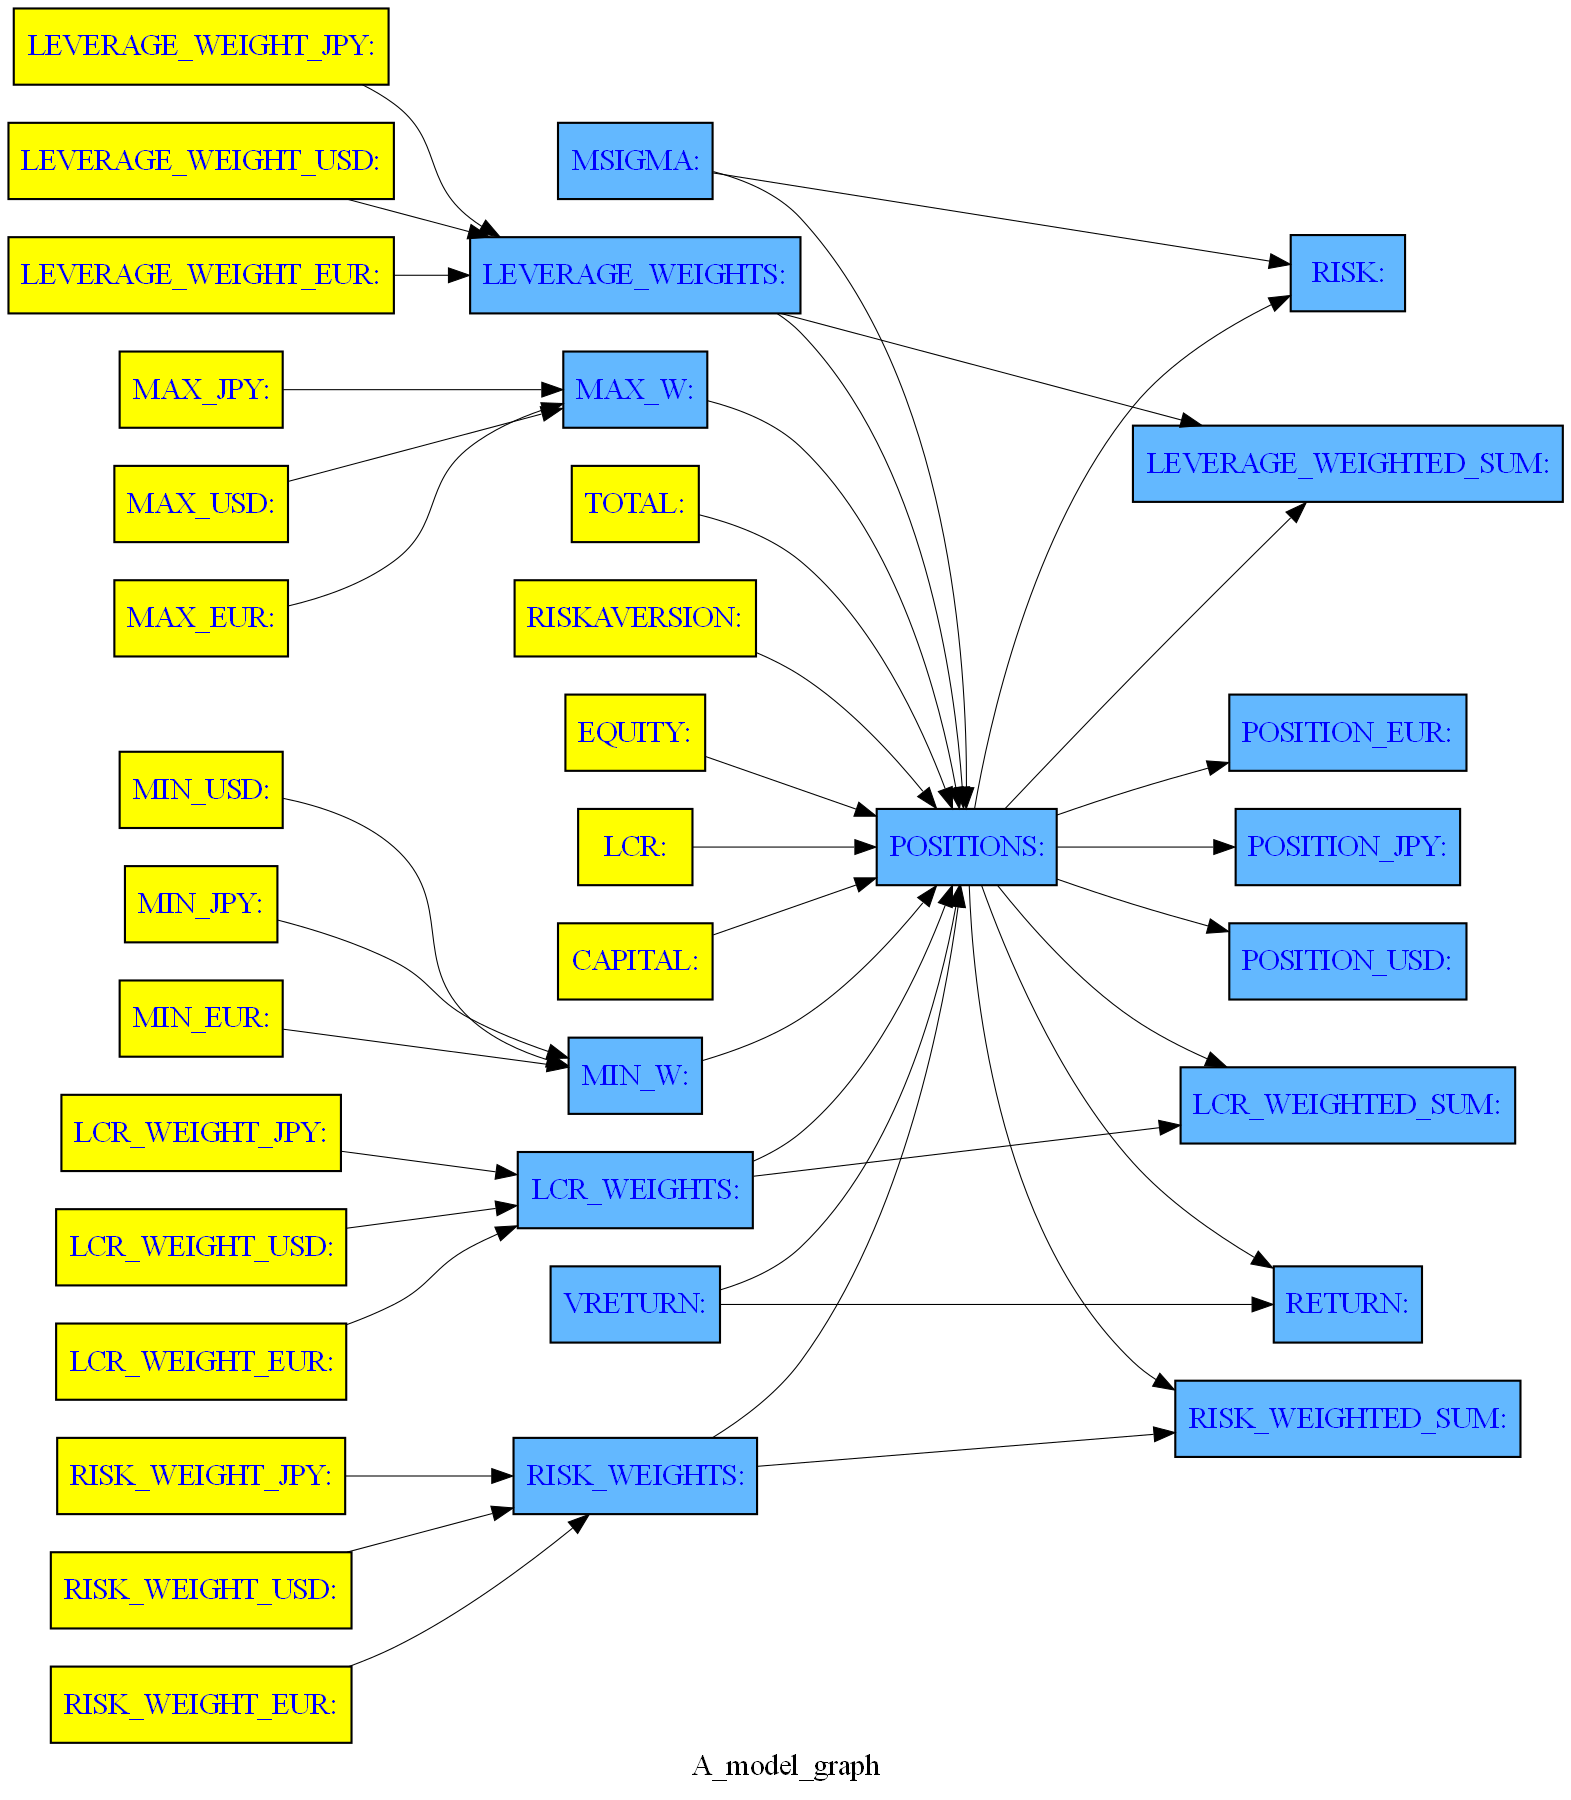

In [5]:
mvaluta.drawmodel(png=1)

### Create a Dataframe

We have defined a model. Let's create some data. 

We are creating a  dataframe, df, with 500 experiments with increasing risk-apatite. 

In [6]:
experiments  = [i  for i in range(500)]                     # make some experiments 
riskaversion = [e/len(experiments) for e in experiments]    # set the risk aversion in each experiment 
temp         = pd.DataFrame(riskaversion,index=experiments,columns=['RISKAVERSION'])  # stuff it into a dataframe
df    = mvaluta.insertModelVar(temp).pipe(lambda df_: df_[sorted([c for c in df_.columns])]) # fill the dataframe

### Assigning values to the exogenous variables 

In [7]:
df.TOTAL     = 10.0

df.MAX_USD   = 90
df.MAX_JPY   = 90
df.MAX_EUR   = 0.   # eur forced to be a liability 

df.MIN_USD   = 0
df.MIN_JPY   = 0
df.MIN_EUR   = -50
df.CAPITAL = 100
df.RISK_WEIGHT_USD = 1
df.RISK_WEIGHT_JPY = 0.5
df.RISK_WEIGHT_EUR = 0.0

df.EQUITY  = 8.
df.LEVERAGE_WEIGHT_USD = 0.5
df.LEVERAGE_WEIGHT_JPY = 0.5
df.LEVERAGE_WEIGHT_EUR = 0.0

df.LCR     = 2
df.LCR_WEIGHT_USD = 0.5
df.LCR_WEIGHT_JPY = 0.1
df.LCR_WEIGHT_EUR = 0.0

## Solve the model for all the experiments  

In [11]:
results = mvaluta(df,start = 0,slut = len(experiments), silent = True )  # Run the model 

### Visualization of results 

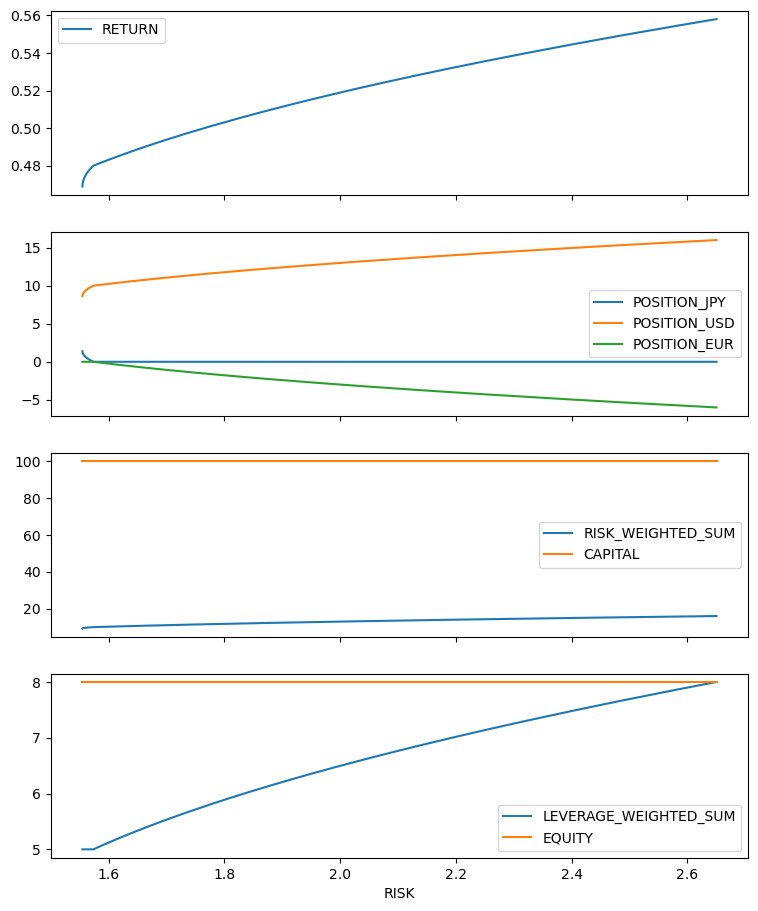

In [9]:
results.RISK = results.RISK.astype('float')
def pplot(vars,ax):
    for v in vars:
        
        _ = results.plot.line(x='RISK',y=v,ax=axes[ax])
        
fig, axes = plt.subplots(nrows=4, ncols=1,  sharex=True,figsize=(9, 11))
pplot(['RETURN'],0)
pplot(['POSITION_JPY','POSITION_USD','POSITION_EUR'],1)
pplot(['RISK_WEIGHTED_SUM','CAPITAL'],2)
pplot(['LEVERAGE_WEIGHTED_SUM','EQUITY'],3)